In [7]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

#### We first define a Ground Truth Model
A simple chain.

In [8]:
np.random.seed(0)

a1 = 1
a2 = 2

N1 = np.random.normal(0, 1, 10000)
N2 = np.random.normal(0, 1, 10000)
N3 = np.random.normal(0, 1, 10000)

X1 = N1
X2 = a1*X1 + N2
X3 = a2*X2 + N3

X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
X3 = X3.reshape(-1,1)

v = [X1,X2,X3]

In [9]:
print(f'X1.shape {X1.shape}, X2.shape {X2.shape}, X3.shape {X3.shape}')
print(f'Var(X1)  = {X1.var():.2f} = V_1 = {N1.var():.2f}')
print(f'Var(X2) = {X2.var():.2f} and V_2 = {N2.var():.2f}')
print(f'Var(X3) = {X3.var():.2f} and V_3 = {N3.var():.2f}')

X1.shape (10000, 1), X2.shape (10000, 1), X3.shape (10000, 1)
Var(X1)  = 0.98 = V_1 = 0.98
Var(X2) = 1.95 and V_2 = 0.99
Var(X3) = 8.81 and V_3 = 0.99


#### We then fit a (series of) Linear Models for each of the 25 DAGs on 3 Nodes

We start with 1-edge models like $X_1\rightarrow X_2 \quad X_3$.

And then follow-up with 2-edge models like $X_1\rightarrow X_2 \leftarrow X_3$.

In [10]:
models = {
    "1": [
            [(1,2)], # each tuple an edge, last number is target (can be multiple initial nodes into target)
            [(2,1)]
         ],
    "2": [
            [(1,3,2)],
            [(1,2),(2,3)]
    ]
}

We first setup the automatic generation of a linear model

In [46]:
def lin_model(m, v):
    lrs = []
    for e in m:
        features = np.hstack([v[:,i] for i in np.array(e)[:-1]-1])
        if len(features.shape) == 1:
            features = features[:,np.newaxis]
        target_ind = e[-1]
        target = v[:,target_ind-1]
        lr = LinearRegression(fit_intercept=False)
        lr.fit(features, target)
        pred = lr.predict(features)
        lrs.append((lr, features, target_ind, target, pred))
    return lrs

We then setup the computation of the *model* MSE

In [58]:
def mse_model(m, lrs, v):
    seen_target_inds = []
    mse = 0
    for e in lrs:
        pred = e[-1]
        target_ind = e[-3]
        target = e[-2]
        mse = mean_squared_error(target, pred)
        seen_target_inds.append(target_ind)
    unmodelled = list(range(1,v.shape[1]+1))
    for ti in seen_target_inds:
        if ti in unmodelled:
            unmodelled.remove(ti)
    if len(unmodelled) > 0:
        v_unmodelled = np.hstack([v[:,i] for i in np.array(unmodelled)-1])
        if len(v_unmodelled.shape) == 1:
            v_unmodelled = v_unmodelled[:,np.newaxis]
        for i in range(v_unmodelled.shape[1]):
            mse += mean_squared_error(np.zeros_like(v_unmodelled[:,i]), v_unmodelled[:,i])
    return mse

We will sanity check using a simple $A\rightarrow B$ model of 2 nodes only.

In [13]:
#%debug
m1 = models["1"][0]
lrs_m1 = lin_model(m1, v)
mse_m1 = mse_model(m1, lrs_m1, v[:2])
m2 = models["1"][1]
lrs_m2 = lin_model(m2, v)
mse_m2 = mse_model(m2, lrs_m2, v[:2])

print(f'Direct calc: MSE(M1)={mse_m1:.2f}\t MSE(M2)={mse_m2:.2f}')

print(f'Sanity check: MSE(M1) = {mean_squared_error(v[1], lrs_m1[0][-1]) + mean_squared_error(np.zeros_like(v[0]), v[0]):.2f}'
      f' < {mean_squared_error(v[0], lrs_m2[0][-1]) + mean_squared_error(np.zeros_like(v[1]), v[1]):.2f} = MSE(M2)')

Direct calc: MSE(M1)=1.96	 MSE(M2)=2.44
Sanity check: MSE(M1) = 1.96 < 2.44 = MSE(M2)


Now a computation for the corresponding 3-node models $A\rightarrow B \quad C$ and $A\leftarrow B \quad C$.

In [14]:
#%debug
m1 = models["1"][0]
lrs_m1 = lin_model(m1, v)
mse_m1 = mse_model(m1, lrs_m1, v)
m2 = models["1"][1]
lrs_m2 = lin_model(m2, v)
mse_m2 = mse_model(m2, lrs_m2, v)

print(f'Direct calc: MSE(M1)={mse_m1:.2f}\t MSE(M2)={mse_m2:.2f}')

print(f'Sanity check: MSE(M1) = {mean_squared_error(v[1], lrs_m1[0][-1]) + mean_squared_error(np.zeros_like(v[0]), v[0]) + mean_squared_error(np.zeros_like(v[2]), v[2]):.2f}'
      f' < {mean_squared_error(v[0], lrs_m2[0][-1]) + mean_squared_error(np.zeros_like(v[1]), v[1]) + mean_squared_error(np.zeros_like(v[2]), v[2]):.2f} = MSE(M2)')

Direct calc: MSE(M1)=10.78	 MSE(M2)=11.25
Sanity check: MSE(M1) = 10.78 < 11.25 = MSE(M2)


Now we will take all 25 DAGs and compute their MSE and then order them, to see
whether the ground truth model $X_1\rightarrow X_2\rightarrow X_3$ will have lowest MSE.

In [15]:
models = {
    "0": [
        []
    ],
    "1": [           # all graphs with 1 edge
            [(1,2)], # each tuple an edge, last number is target (can be multiple initial nodes into target)
            [(2,3)],
            [(1,3)],
            [(3,1)],
            [(2,1)],
            [(3,2)],
         ],
    "2": [           # all graphs with 2 edges
            [(1,2),(2,3)],
            [(2,1),(3,2)],
            [(1,3,2)],
            [(2,1),(2,3)],
            [(1,3),(1,2)],
            [(3,1),(1,2)],
            [(1,2,3)],
            [(3,1),(2,3)],
            [(1,3),(2,1)],
            [(3,2,1)],
            [(1,3),(3,2)],
            [(3,1),(3,2)],
    ],
    "3": [
            [(1,2,3),(1,2)],
            [(3,2,1),(3,2)],
            [(1,3),(1,3,2)],
            [(3,1),(1,3,2)],
            [(1,2,3),(2,1)],
            [(3,2,1),(2,3)],
    ]
    
}
print(f'Total Num of DAGs {sum([len(models[str(i)]) for i in range(3+1)])}')

Total Num of DAGs 25


In [16]:
#%debug
models_scored = []
for i in range(3+1):
    for m in models[str(i)]:
        lrs_m = lin_model(m, v)
        mse_m = mse_model(m, lrs_m, v)
        #print(f'Model ({i} edges): {str(m)}\t\t MSE(M)={mse_m:.2f}')
        models_scored.append((m, i, mse_m))
df = pd.DataFrame(models_scored, columns=["Model", "Number of Edges", "MSE(Model)"])
print(df)

                  Model  Number of Edges  MSE(Model)
0                    []                0   11.736114
1              [(1, 2)]                1   10.776068
2              [(2, 3)]                1    3.916369
3              [(1, 3)]                1    7.887083
4              [(3, 1)]                1   11.310083
5              [(2, 1)]                1   11.254869
6              [(3, 2)]                1   10.009446
7      [(1, 2), (2, 3)]                2    1.970107
8      [(2, 1), (3, 2)]                2    9.033838
9           [(1, 3, 2)]                2    9.987383
10     [(2, 1), (2, 3)]                2    2.940762
11     [(1, 3), (1, 2)]                2    1.961824
12     [(3, 1), (1, 2)]                2    9.800460
13          [(1, 2, 3)]                2    3.916361
14     [(3, 1), (2, 3)]                2    2.940762
15     [(1, 3), (2, 1)]                2    2.440625
16          [(3, 2, 1)]                2   11.254865
17     [(1, 3), (3, 2)]                2    1.

Sorting using MSE scores now.

In [17]:
df.sort_values('MSE(Model)')

,Model,Number of Edges,MSE(Model)
21,"[(1, 3), (1, 3, 2)]",3,1.173139
17,"[(1, 3), (3, 2)]",2,1.195202
11,"[(1, 3), (1, 2)]",2,1.961824
19,"[(1, 2, 3), (1, 2)]",3,1.961824
7,"[(1, 2), (2, 3)]",2,1.970107
23,"[(1, 2, 3), (2, 1)]",3,2.440625
15,"[(1, 3), (2, 1)]",2,2.440625
14,"[(3, 1), (2, 3)]",2,2.940762
10,"[(2, 1), (2, 3)]",2,2.940762
24,"[(3, 2, 1), (2, 3)]",3,2.940762


Let's define varsortability (the formula from Reisach et al.) first

In [18]:
def model_to_adj(m):
    adj = np.zeros((3,3))
    for e in m:
        for k in e[:-1]:
            adj[k-1,e[-1]-1] = 1
    return adj

print(f'model: {models["1"][0]}\n adj:\n{model_to_adj(models["1"][0])}')
print(f'model: {models["3"][2]}\n adj:\n{model_to_adj(models["3"][2])}')

model: [(1, 2)]
 adj:
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
model: [(1, 3), (1, 3, 2)]
 adj:
[[0. 1. 1.]
 [0. 0. 0.]
 [0. 1. 0.]]


In [19]:
adj = model_to_adj(models["3"][2])

def active_edges(adj):
    l = []
    for i, k in enumerate(adj.flatten()):
        if k:
            l.append(np.hstack(np.unravel_index([i], adj.shape)))
    return l

print(active_edges(adj))

[array([0, 1]), array([0, 2]), array([2, 1])]


In [20]:
def varsort(adj, data):
    if np.allclose(adj, np.zeros(adj.shape)):
        return 0
    sum_num = 0
    sum_den = 0
    for k in range(1,len(adj)):
        for e in active_edges(np.linalg.matrix_power(adj,k)):
            var_i = np.var(data[e[0]])
            var_j = np.var(data[e[1]])
            if var_i < var_j:
                sum_num += 1
            elif var_i > var_j:
                sum_num += 0
            else:
                sum_num += .5
            sum_den += 1
    return sum_num / sum_den

As expected, the linear Gauss chain reveals a perfect varsortability score since variance increases along the chain

In [21]:
adj = model_to_adj(models["2"][0]) # chain, true graph
vs = varsort(adj, v)
print(vs)

1.0


Considering the actual variance ordering for the 25 DAGs, we have

In [22]:
vs = []
for i in range(3+1):
    for m in models[str(i)]:
        vs.append(varsort(model_to_adj(m), v))
df['Var-Sort'] = vs
df.sort_values(['Var-Sort','MSE(Model)'], ascending=[False,True]).round(2)

,Model,Number of Edges,MSE(Model),Var-Sort
11,"[(1, 3), (1, 2)]",2,1.96,1.00
19,"[(1, 2, 3), (1, 2)]",3,1.96,1.00
7,"[(1, 2), (2, 3)]",2,1.97,1.00
13,"[(1, 2, 3)]",2,3.92,1.00
2,"[(2, 3)]",1,3.92,1.00
3,"[(1, 3)]",1,7.89,1.00
1,"[(1, 2)]",1,10.78,1.00
21,"[(1, 3), (1, 3, 2)]",3,1.17,0.75
23,"[(1, 2, 3), (2, 1)]",3,2.44,0.75
17,"[(1, 3), (3, 2)]",2,1.20,0.67


Since NT optimizes for DAGs, one of the 25 graphs shown in this 3 node case is certainly the solution (when converged), furthermore, NT is allegedly only optimizing Model MSE (variances) which means it will be one of the top graphs, *furthermore, a perfect varsortability suggests that NT can simply sort the variances for easier MSE computation* so it will be one of the top graphs shown there - since they are all pretty much same MSE wise, it would feel like it always chooses one of those. (Furthermore, NT regularizes for sparsity, kicks out 2 as well because of 3 edges.)

Let's try different parameters, different graphs, in hope of a pattern.

In [23]:
a1 = 2
a2 = 0

N1 = np.random.normal(0, 1, 10000)
N2 = np.random.normal(0, 2, 10000)
N3 = np.random.normal(0, 5, 10000)

X1 = N1
X2 = a1*X1 + N2
X3 = a2*X2 + N3

X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
X3 = X3.reshape(-1,1)

v = [X1,X2,X3]
models_scored = []
for i in range(3+1):
    for m in models[str(i)]:
        lrs_m = lin_model(m, v)
        mse_m = mse_model(m, lrs_m, v)
        #print(f'Model ({i} edges): {str(m)}\t\t MSE(M)={mse_m:.2f}')
        models_scored.append((m, i, mse_m))
df = pd.DataFrame(models_scored, columns=["Model", "Number of Edges", "MSE(Model)"])
vs = []
for i in range(3+1):
    for m in models[str(i)]:
        vs.append(varsort(model_to_adj(m), v))
df['Var-Sort'] = vs
df.sort_values(['Var-Sort','MSE(Model)'], ascending=[False,True]).round(2)

,Model,Number of Edges,MSE(Model),Var-Sort
11,"[(1, 3), (1, 2)]",2,4.99,1.00
19,"[(1, 2, 3), (1, 2)]",3,4.99,1.00
7,"[(1, 2), (2, 3)]",2,25.98,1.00
1,"[(1, 2)]",1,29.95,1.00
13,"[(1, 2, 3)]",2,33.92,1.00
3,"[(1, 3)]",1,33.92,1.00
2,"[(2, 3)]",1,33.92,1.00
21,"[(1, 3), (1, 3, 2)]",3,4.99,0.75
23,"[(1, 2, 3), (2, 1)]",3,8.45,0.75
15,"[(1, 3), (2, 1)]",2,8.45,0.67


06.05.22, Experiment

Given a chain, it suffices to change the variance ordering of first-last node pair only, to have a lower MSE in the changed one (i.e., NT can still choose to do collider since that is the exact varsortation, but MSE of attacked will be lower of truth as well).

In [63]:
a1 = 1
a2 = 1

N1 = np.random.normal(0, 1, 10000)
N2 = np.random.normal(0, 1, 10000)
N3 = np.random.normal(0, 1, 10000)

X1 = N1
X2 = a1*X1 + N2
X3 = a2*X2 + N3

X1 = X1.reshape(-1,1)
X2 = X2.reshape(-1,1)
X3 = X3.reshape(-1,1)

v = np.hstack([X1,X2,X3])

print(f'X1.shape {X1.shape}, X2.shape {X2.shape}, X3.shape {X3.shape}')
print(f'Var(X1)  = {v[:,0].var():.2f} = V_1 = {N1.var():.2f}')
print(f'Var(X2) = {v[:,1].var():.2f} and V_2 = {N2.var():.2f}')
print(f'Var(X3) = {v[:,2].var():.2f} and V_3 = {N3.var():.2f}')

models_scored = []
models = [[(1,2),(2,3)],[(3,2),(2,1)],[(1,2),(3,2)]]
for m in models:
    lrs_m = lin_model(m, v)
    mse_m = mse_model(m, lrs_m, v)
    models_scored.append((m, mse_m))
df = pd.DataFrame(models_scored, columns=["Model", "MSE(Model)"])
print(df)

# now perform scaling (attack)
models_scored = []
v[:,0] = 4*v[:,0]
print("\n\n After Attack:")
print(f'Var(X1)  = {v[:,0].var():.2f} = V_1 = {N1.var():.2f}')
print(f'Var(X2) = {v[:,1].var():.2f} and V_2 = {N2.var():.2f}')
print(f'Var(X3) = {v[:,2].var():.2f} and V_3 = {N3.var():.2f}')
for m in models:
    lrs_m = lin_model(m, v)
    mse_m = mse_model(m, lrs_m, v)
    models_scored.append((m, mse_m))
df = pd.DataFrame(models_scored, columns=["Model", "MSE(Model)"])
print(df)

X1.shape (10000, 1), X2.shape (10000, 1), X3.shape (10000, 1)
Var(X1)  = 0.99 = V_1 = 0.99
Var(X2) = 2.00 and V_2 = 0.99
Var(X3) = 3.00 and V_3 = 0.99
              Model  MSE(Model)
0  [(1, 2), (2, 3)]    1.982747
1  [(3, 2), (2, 1)]    3.497147
2  [(1, 2), (3, 2)]    2.657782


 After Attack:
Var(X1)  = 15.86 = V_1 = 0.99
Var(X2) = 2.00 and V_2 = 0.99
Var(X3) = 3.00 and V_3 = 0.99
              Model  MSE(Model)
0  [(1, 2), (2, 3)]   16.854114
1  [(3, 2), (2, 1)]   10.894219
2  [(1, 2), (3, 2)]   10.093466


### Regular 2-node Case $A\rightarrow B$ or $A\leftarrow B$

This is the regular setting from Reisach et al.
It is important to note that $MSE(M)$ is for some model $M$ and refers to the sum of all residuals.
I.e., $MSE(X) = \sum_i Y-aX = Var(Y-aX)$ whereas $MSE(M) = \sum_i MSE(X_i)$ with $MSE(X)=0$ if $X$ is not predicted.

In [14]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

In [15]:
np.random.seed(0)
w = 0.5
NX = np.random.normal(0, 1, 10000)
NY = np.random.normal(0, 1, 10000)
X = NX
Y = w*X + NY
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

In [16]:
print(f'Var(X) = V_X = {X.var():.2f}')
print(f'Var(Y) = {Y.var():.2f} and V_Y = {NY.var():.2f}')

Var(X) = V_X = 0.98
Var(Y) = 1.22 and V_Y = 0.99


In [17]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X, Y)
pred_x_y = lr.predict(X)

In [18]:
mse_x_y = mean_squared_error(Y, pred_x_y)

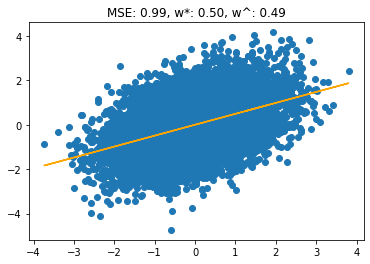

In [19]:
import matplotlib.pyplot as plt
plt.scatter(X,Y)
plt.plot(X,pred_x_y,c="orange")
plt.title(f'MSE: {mse_x_y:.2f}, w*: {w:.2f}, w^: {lr.coef_[0][0]:.2f}')
plt.show()

In [20]:
lr2 = LinearRegression(fit_intercept=False)
lr2.fit(Y, X)
pred_y_x = lr2.predict(Y)

In [21]:
mse_y_x = mean_squared_error(X, pred_y_x)

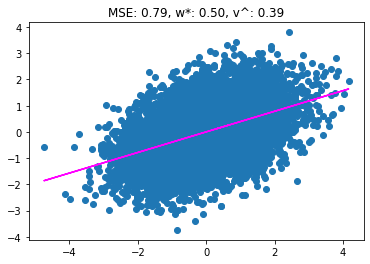

In [22]:
plt.scatter(Y,X)
plt.plot(Y,pred_y_x,c="magenta")
plt.title(f'MSE: {mse_y_x:.2f}, w*: {w:.2f}, v^: {lr2.coef_[0][0]:.2f}')
plt.show()

In [24]:
cov_XY = np.cov(np.hstack((X, Y)).T)
print(cov_XY) # cov(X,X) = var(X) and cov(Y,Y) = var(Y) and cov(X,Y) = cov(Y,X))
print(f'w^ = {lr.coef_[0][0]:.2f} approx cov(X,Y)/var(X) = {cov_XY[0,1]/cov_XY[0,0]:.2f}\n'
     f'v^ = {lr2.coef_[0][0]:.2f} approx cov(X,Y)/var(Y) = {cov_XY[0,1]/cov_XY[1,1]:.2f}')

[[0.97536551 0.48007249]
 [0.48007249 1.22248734]]
w^ = 0.49 approx cov(X,Y)/var(X) = 0.49
v^ = 0.39 approx cov(X,Y)/var(Y) = 0.39


Here we simply assert that the coefficients that we learned match the analytical derivation.

In [25]:
print(np.allclose(pred_x_y, lr.coef_[0][0]*X))
print(np.allclose(pred_y_x, lr2.coef_[0][0]*Y))

True
True


In [26]:

print(f'MSE = {mse_x_y:.2f} < {mse_y_x:.2f} = MSE '
      '<==>'
      f' [Var(X) {cov_XY[0,0]:.2f} + Var(Y-w^X) {np.var(Y-pred_x_y):.2f}] = {cov_XY[0,0]+np.var(Y-pred_x_y):.2f} '
     f'< {cov_XY[1,1]+np.var(X-pred_y_x):.2f} = [Var(Y) {cov_XY[1,1]:.2f} + Var(X-v^Y) {np.var(X-pred_y_x):.2f}]\n')


MSE = 0.99 < 0.79 = MSE <==> [Var(X) 0.98 + Var(Y-w^X) 0.99] = 1.96 < 2.01 = [Var(Y) 1.22 + Var(X-v^Y) 0.79]



Indeed, if we have the proper $MSE(M)$ which adds to $V(B-wA)$ the term $V(A)$ (since $A$ is not predicted), then the inequality holds and $MSE$ infers the right model.

In [27]:

print(f'MSE(M1) = {mse_x_y + mean_squared_error(np.zeros_like(X), X):.2f} < {mse_y_x + mean_squared_error(np.zeros_like(Y), Y):.2f} = MSE(M2) '
      '<==>'
      f' [Var(X) {cov_XY[0,0]:.2f} + Var(Y-w^X) {np.var(Y-pred_x_y):.2f}] = {cov_XY[0,0]+np.var(Y-pred_x_y):.2f} '
     f'< {cov_XY[1,1]+np.var(X-pred_y_x):.2f} = [Var(Y) {cov_XY[1,1]:.2f} + Var(X-v^Y) {np.var(X-pred_y_x):.2f}]\n')


MSE(M1) = 1.96 < 2.01 = MSE(M2) <==> [Var(X) 0.98 + Var(Y-w^X) 0.99] = 1.96 < 2.01 = [Var(Y) 1.22 + Var(X-v^Y) 0.79]

